# Data and Concept Drift

1. Once a production a model sees certain data for prediction
1. We hope that data matches shape and distribution of the data we used to train the model
1. We also hope that our model performs well on new data and that its performance does not degrade over time
1. Experience reports of the contrary
   * Regularly data distributions change and model performance is not good
1. We need a workflow to detect that
1. It is also desirable to make the work we did in step 1 reproducable

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
tf.random.set_seed(42)

In [3]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

Tue Oct 26 17:08:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.50       Driver Version: 471.21       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8    10W /  N/A |   2214MiB / 16384MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np
np.__version__

'1.19.5'

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [6]:
!pip install -q dtreeviz

In [7]:
from dtreeviz import clfviz

In [8]:
def plot_decision_boundaries(model, X, y_true):
  _, ax = plt.subplots(figsize=(8,4), dpi=300)

  clfviz(
              model, X, y_true, 
             show=['instances', 'boundaries', 'probabilities', 'misclassified'],
             markers=['v', '^', 'd'],
             ntiles=50, 
             ax=ax,
             tile_fraction=1.0, 
             boundary_markersize=1.0,
             feature_names=["Age", "Max Speed"],
             colors={'class_boundary': 'black',
                     'tile_alpha': 0.5,
                    #  'warning' : 'yellow',
                     'classes':
                         [None,  # 0 classes
                          None,  # 1 class
                          None,  # 2 classes
                          ['#FF8080', '#FFFF80', '#8080FF'],  # 3 classes
                          ]
                     }
               )

# Step 1: Loading and exploring our data set

https://colab.research.google.com/github/embarced/notebooks/blob/master/mlops/generate.ipynb?hl=en

This is a database of customers of an insurance company. Each data point is one customer. Risk is expressed as a number between 0 and 1. 1 meaning highest and 0 meaning lowerst risk of having an accident.

In [9]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/embarced/notebooks/master/mlops/insurance-customers-risk-1500.csv')
df.head()

,speed,age,miles,group,risk
0,97.0,44.0,30.0,1,0.597611
1,135.0,63.0,29.0,1,0.452710
2,111.0,26.0,34.0,0,0.750234
3,97.0,25.0,10.0,1,0.325249
4,114.0,38.0,22.0,2,0.269731


In [10]:
df.describe()

,speed,age,miles,group,risk
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.323333,44.989333,30.384000,0.999333,0.505887
std,17.417147,17.145297,15.214166,0.817177,0.256517
min,80.000000,16.000000,1.000000,0.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000,0.319750
50%,120.000000,42.000000,29.000000,1.000000,0.502173
75%,137.000000,54.000000,42.000000,2.000000,0.685074
max,166.000000,100.000000,84.000000,2.000000,1.000000


In [11]:
df_shifted = pd.read_csv('https://raw.githubusercontent.com/embarced/notebooks/master/mlops/insurance-customers-risk-1500-shift.csv')
df_shifted.describe()

,speed,age,miles,group,risk
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,121.447333,47.225333,29.976667,1.124000,0.475828
std,17.027248,18.815381,16.276509,0.781258,0.251383
min,72.000000,16.000000,1.000000,0.000000,0.000000
25%,107.000000,34.000000,17.000000,0.000000,0.289465
50%,122.000000,44.000000,29.000000,1.000000,0.459563
75%,137.000000,57.000000,44.000000,2.000000,0.666139
max,173.000000,100.000000,80.000000,2.000000,1.000000


In [12]:
!curl -O https://raw.githubusercontent.com/embarced/notebooks/master/tfx/classifier.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3056k  100 3056k    0     0  5225k      0 --:--:-- --:--:-- --:--:-- 5225k


In [13]:
model = tf.keras.models.load_model("classifier.h5")

In [14]:
y = df['group'].values
# add more columns to list to have fewer features to train on
X = df.drop(['risk', 'group', 'miles'], axis='columns').values
# reorder, first age, then speed to match plotting
X = pd.DataFrame(np.array([X[:, 1], X[:, 0]]).T)
X.shape, y.shape

((1500, 2), (1500,))

In [15]:
loss, metric = model.evaluate(X, y)
loss, metric

47/47 [==============================] - 1s 5ms/step - loss: 0.7263 - accuracy: 0.6947


(0.7262932658195496, 0.6946666836738586)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


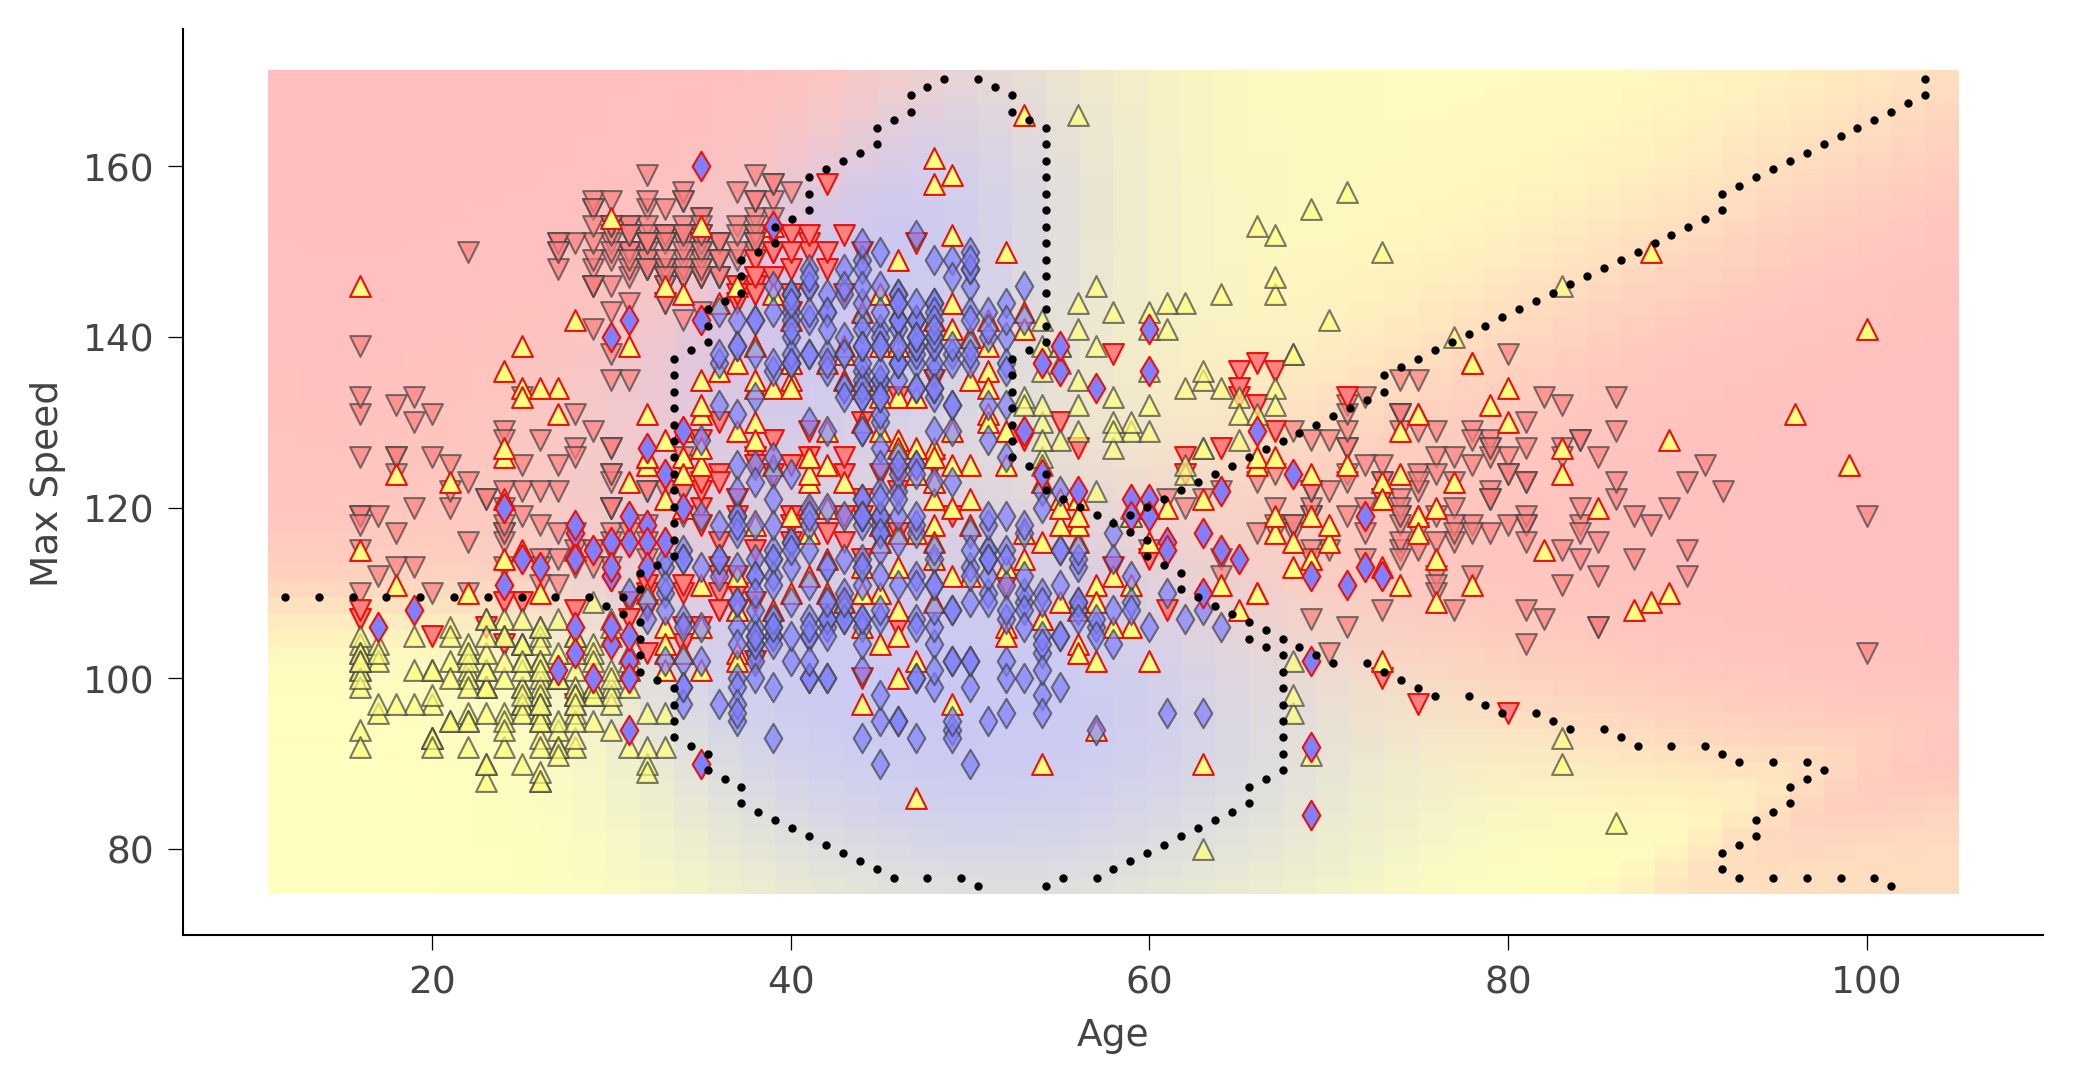

In [16]:
plot_decision_boundaries(model, X, y)

In [17]:
y_shifted = df_shifted['group'].values
# add more columns to list to have fewer features to train on
X_shifted = df_shifted.drop(['risk', 'group', 'miles'], axis='columns').values
# reorder, first age, then speed to match plotting
X_shifted = pd.DataFrame(np.array([X_shifted[:, 1], X_shifted[:, 0]]).T)
X_shifted.shape, y_shifted.shape

((1500, 2), (1500,))

In [18]:
loss, metric = model.evaluate(X_shifted, y_shifted)
loss, metric

47/47 [==============================] - 0s 5ms/step - loss: 0.7475 - accuracy: 0.6740


(0.747498631477356, 0.6740000247955322)

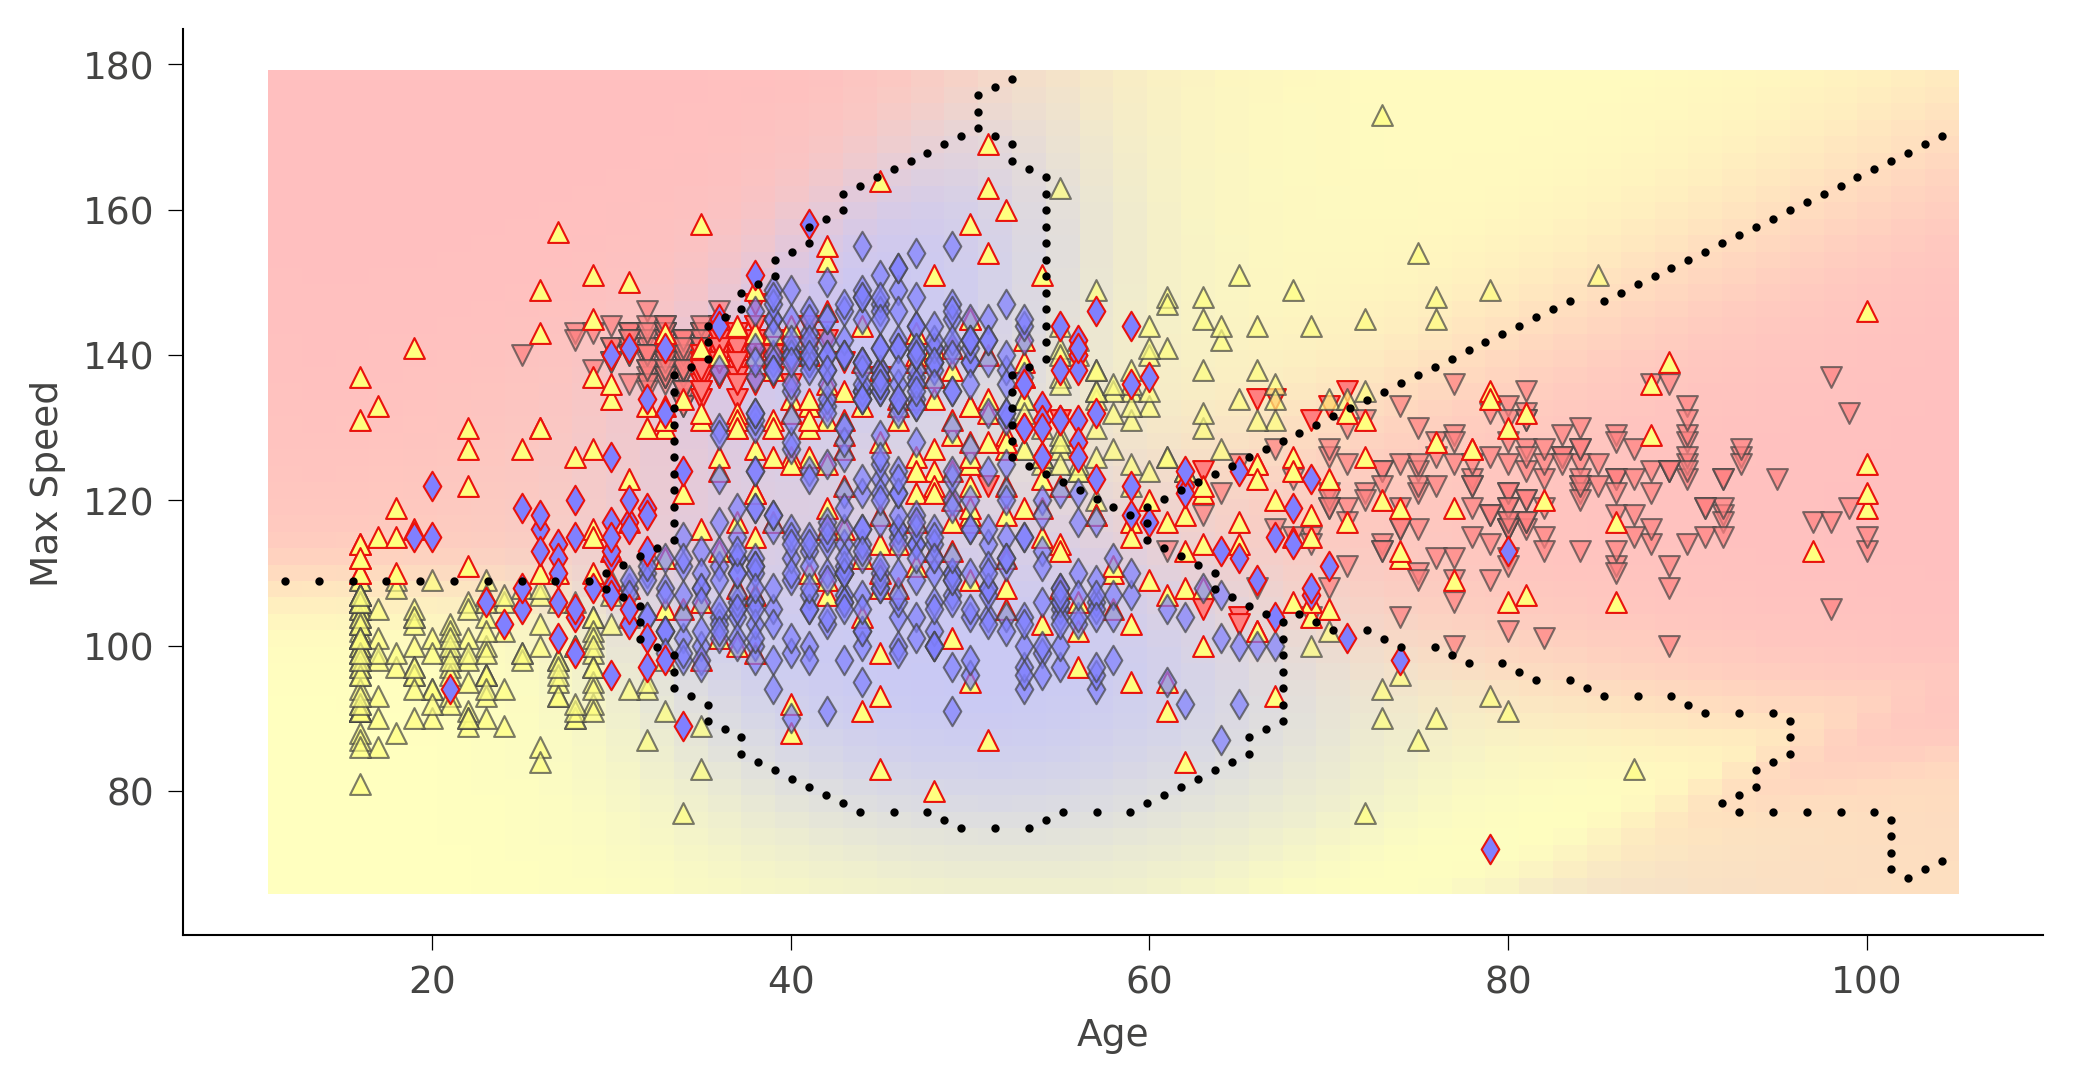

In [19]:
plot_decision_boundaries(model, X_shifted, y_shifted)